In [1]:
def is_start_of_daily_block(date_series):
    """
    Returns a boolean Series indicating if each date in the input Series is the 
    start of a new sequence of consecutive dates.

    :param date_series: Pandas Series with datetime objects.
    :return: Pandas Series of boolean values.
    """
    # Ensure the Series is sorted
    sorted_series = date_series.sort_values()

    # Calculate the difference in days between each date and the previous date
    day_diff = sorted_series.diff().dt.days

    # Mark True where the difference is greater than 1 day, indicating a new sequence
    is_start = day_diff > 1

    # Handle the first element
    if not is_start.empty:
        is_start.iloc[0] = True

    return is_start

In [2]:
def clean_data(df):
    df = df[(df['Extruder Pressure'] >= 0) & (df['Extruder Pressure'] < 50000)]
    
    return df

In [3]:
def get_machine_pauses(df, time_threshold=30, index=True):
    if index:
        time_diff = -1*(df.index.diff(-1).dt.total_seconds()/60)
        machine_pauses = df[time_diff > time_threshold].index
    else:
        time_diff = -1*(df['Date and Time'].diff(-1).dt.total_seconds()/60)
        machine_pauses = df[time_diff > time_threshold]['Date and Time']
    
    return machine_pauses

def calculate_time_difference(df, time_threshold=30):
    time_diff = -1*(df['Date and Time'].diff(-1).dt.total_seconds()/60)
    #time_diff = (df['Date and Time'].shift(-1) - df['Date and Time']).dt.total_seconds()/60

    return time_diff

In [4]:
import utils

In [5]:
def clean_extruder_data(extruder_data):
    
    extruder_data = extruder_data.drop(extruder_data.index[0])
    extruder_data = extruder_data.replace("<null>", None)
    
    extruder_data = extruder_data.dropna()

    # Convert the column to string type
    for column in extruder_data.columns:
        if column not in ["Date and Time", "AnomalyScore"]:
            extruder_data[column] = extruder_data[column].astype(str)
            #extruder_data[column] = extruder_data[column].str.replace("<null>", None)
            # Replace commas with an empty string
            extruder_data[column] = extruder_data[column].str.replace(",", "")

            # Convert the column back to numeric type, handling any conversion errors
            extruder_data[column] = pd.to_numeric(extruder_data[column], errors="coerce")
            
    extruder_data = extruder_data[(extruder_data['Extruder Pressure'] >= 0) & \
                              (extruder_data['Extruder Pressure'] < 50000)]

    extruder_data['Date and Time'] = pd.to_datetime(extruder_data['Date and Time'])
    
    return extruder_data

In [6]:
import pandas as pd
import re

columns_oi = ['Extruder Pressure']

ex4_data = clean_extruder_data( pd.read_csv("ex4-data.csv") )

/tmp/ipykernel_9247/3404226215.py:6: DtypeWarning: Columns (2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  ex4_data = clean_extruder_data( pd.read_csv("ex4-data.csv") )


In [7]:

ex4_data = ex4_data.groupby('Date and Time').mean()

# resampling every 5 minutes instead of 1 minute

ex4_resampled = ex4_data.resample('5T').mean()

In [8]:

ex4_data['Date and Time'] = ex4_data.index
ex4_pauses = get_machine_pauses(ex4_data, time_threshold=15, index=False)

pauses = ex4_pauses

In [9]:
def hours_since_last_pause(time, pauses):
    return (time - pauses[pauses <= time].max()).total_seconds()/3600

def hours_to_next_pause(time, pauses):
    return (pauses[pauses >= time].min() - time).total_seconds()/3600

In [10]:
%%time
#from tqdm import tqdm

ex4_data['hours_since_last_pause'] = ex4_data.index.to_series().apply(
    lambda x : hours_since_last_pause(x, pauses)
)
ex4_data['hours_to_next_pause'] = ex4_data.index.to_series().apply(
    lambda x : hours_to_next_pause(x, pauses)
)

CPU times: user 34.4 s, sys: 14.2 ms, total: 34.4 s
Wall time: 34.4 s


In [11]:

for time_window in ['15T', '30T', '1H', '2H', '3H', '6H', '12H']:
    if 'T' in time_window:
        label_append = time_window.replace('T', 'min')
    elif 'H' in time_window:
        label_append = time_window.replace('H', 'hour')

    col_label = 'pressure-' + label_append + '_avg'
    ex4_data[col_label] = ex4_data['Extruder Pressure'].rolling(time_window).mean()

In [12]:
variables_to_lag = ['Extruder Die Temp', 'Extruder Thrust',
                    'Screw Speed Output']

colname_map = {
    'Extruder Die Temp' : 'die_temp-',
    'Extruder Thrust' : 'thrust-',
    'Screw Speed Output' : 'screw_speed_output-',
}

for time_window in ['15T', '1H', '3H']:
    if 'T' in time_window:
        label_append = time_window.replace('T', 'min')
    elif 'H' in time_window:
        label_append = time_window.replace('H', 'hour')
    for lagvar in variables_to_lag:
        col_label = colname_map[lagvar] + label_append + '_avg'
        ex4_data[col_label] = \
            ex4_data[lagvar].rolling(time_window).mean()

In [13]:
min_datetime = pauses.min() - pd.Timedelta(days=7)
max_datetime = pauses.max()

time_mask = (ex4_data.index >= min_datetime) \
            & (ex4_data.index <= max_datetime)
ex4_data = ex4_data[time_mask]

redundancy_mask = (ex4_data['hours_since_last_pause'] >= 3) \
                  | (ex4_data['hours_to_next_pause'] >= 3)
ex4_data = ex4_data[redundancy_mask]

In [14]:
# set up classifier variables -
# whether there is a pause within 
# {1 minute, 5 minutes, 10 minutes, 15 minutes, 30 minutes,
#  1 hour, 2 hours, 3 hours, 6 hours, 12 hours, 24 hours}

stop_target_to_hours_map = {
    '5min' : 5/60,
    '10min': 10/60,
    '15min': 15/60,
    '30min': 30/60,
    '1hour': 1,
    '2hour': 2,
    '3hour': 3,
    '6hour':6,
    '12hour':12,
    '24hour':24,
}


for window in stop_target_to_hours_map:
    ex4_data[f'{window}_stop'] = \
        ex4_data['hours_to_next_pause'] < stop_target_to_hours_map[window]

In [15]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def balance_dataset(X, y, over_sample_ratio=0.1, under_sample_ratio=0.5):
    """
    Balances the dataset by over-sampling the minority class and under-sampling the majority class.

    :param X: Feature set.
    :param y: Labels.
    :param over_sample_ratio: Ratio of the number of samples in the minority class after resampling
                              to the number of samples in the majority class before resampling.
    :param under_sample_ratio: Ratio of the number of samples in the majority class after resampling
                               to the number of samples in the minority class after over-sampling.

    :return: Balanced features and labels.
    """
    
    # Define the resampling strategy
    over = SMOTE(sampling_strategy=over_sample_ratio)
    under = RandomUnderSampler(sampling_strategy=under_sample_ratio)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)

    # Transform the dataset
    X_balanced, y_balanced = pipeline.fit_resample(X, y)

    return X_balanced, y_balanced

In [16]:
target_features = [s+ '_stop' for s in stop_target_to_hours_map.keys()]
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-15min_avg',
    'pressure-30min_avg',
    'pressure-1hour_avg',
    'pressure-2hour_avg',
    'pressure-3hour_avg',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'die_temp-3hour_avg',
    'thrust-3hour_avg',
]

In [17]:
ex4_data.head()

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%),Date and Time,hours_since_last_pause,...,5min_stop,10min_stop,15min_stop,30min_stop,1hour_stop,2hour_stop,3hour_stop,6hour_stop,12hour_stop,24hour_stop
Date and Time,,,,,,,,,,,,,,,,,,,,,
2023-01-08 18:56:00,4490.480000,25.0,-0.94,10.88,48.900,5.25,0.9,80.0,2023-01-08 18:56:00,NaN,...,False,False,False,False,False,False,False,False,False,False
2023-01-08 18:58:00,4304.433333,25.0,-0.94,10.88,49.815,4.37,0.9,80.0,2023-01-08 18:58:00,NaN,...,False,False,False,False,False,False,False,False,False,False
2023-01-08 18:59:00,4215.190000,25.0,-0.94,10.88,49.700,0.00,0.9,80.0,2023-01-08 18:59:00,NaN,...,False,False,False,False,False,False,False,False,False,False
2023-01-08 19:01:00,3972.940000,25.0,-0.94,10.88,50.610,0.00,0.9,80.0,2023-01-08 19:01:00,NaN,...,False,False,False,False,False,False,False,False,False,False
2023-01-08 19:03:00,3972.940000,25.0,-0.94,10.88,50.610,5.97,0.9,80.0,2023-01-08 19:03:00,NaN,...,False,False,False,False,False,False,False,False,False,False


In [18]:
ex4_data.index.min(),  ex4_data.index.max()

(Timestamp('2023-01-08 18:56:00'), Timestamp('2023-04-25 18:10:00'))

In [19]:
model_input = ex4_data[input_features]
model_output = ex4_data[target_features]

In [20]:
train_split_cutoff = pd.to_datetime('04/01/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
pressure-15min_avg
pressure-30min_avg
pressure-1hour_avg
pressure-2hour_avg
pressure-3hour_avg
die_temp-15min_avg
thrust-15min_avg
screw_speed_output-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
screw_speed_output-1hour_avg
die_temp-3hour_avg
thrust-3hour_avg
screw_speed_output-3hour_avg
original true samples: 34, original false samples: 33137
balanced true samples: 3313, balanced false samples: 6626

Current Time: 08:46:38
results for target: 5min_stop, model: Logistic Regression


/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


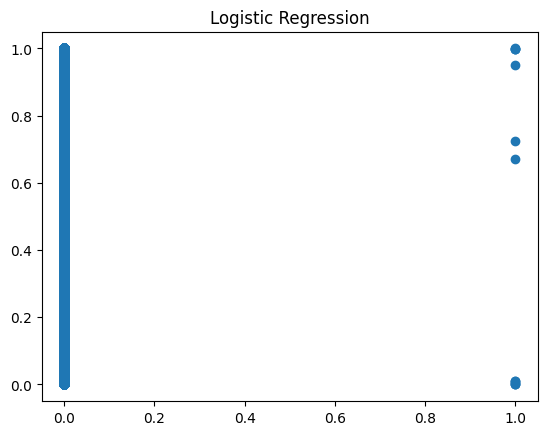

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.5973539491511916, 'Cross-Val Mean': 0.998250173270067, 'Confusion_Matrix': array([[7488, 5046],
       [   6,    7]])}
--------------------------------------
Run time: 0.04 minutes
Current Time: 08:46:40
--------------------------------------

Current Time: 08:46:40
results for target: 5min_stop, model: Random Forest


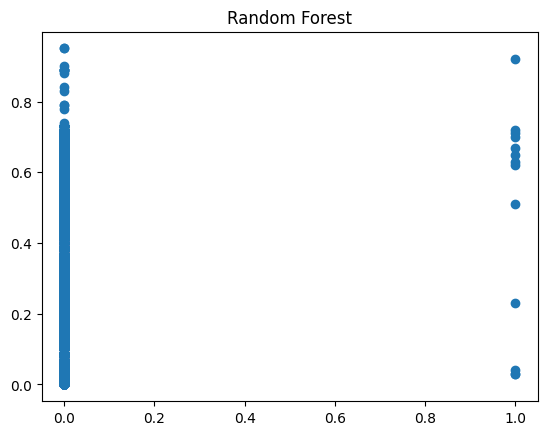

{'Accuracy': 0.7568343030206424, 'Cross-Val Mean': 0.8371828090831313, 'Confusion_Matrix': array([[9487, 3047],
       [   4,    9]])}
--------------------------------------
Run time: 0.43 minutes
Current Time: 08:47:04
--------------------------------------

Current Time: 08:47:04
results for target: 5min_stop, model: Support Vector Machine
{'Accuracy': 0.09516219016497968, 'Cross-Val Mean': 0.9989719604392118, 'Confusion_Matrix': array([[ 1185, 11349],
       [    4,     9]])}
--------------------------------------
Run time: 0.50 minutes
Current Time: 08:47:08
--------------------------------------

Current Time: 08:47:08
results for target: 5min_stop, model: K-Nearest Neighbors


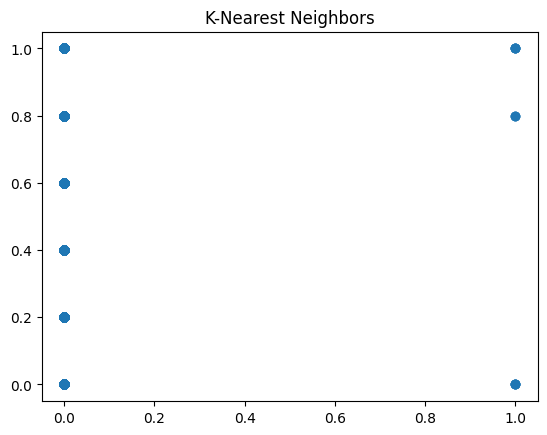

{'Accuracy': 0.48059297043117877, 'Cross-Val Mean': 0.9984470260560098, 'Confusion_Matrix': array([[6022, 6512],
       [   5,    8]])}
--------------------------------------
Run time: 0.54 minutes
Current Time: 08:47:11
--------------------------------------

Current Time: 08:47:11
results for target: 5min_stop, model: Gradient Boosting


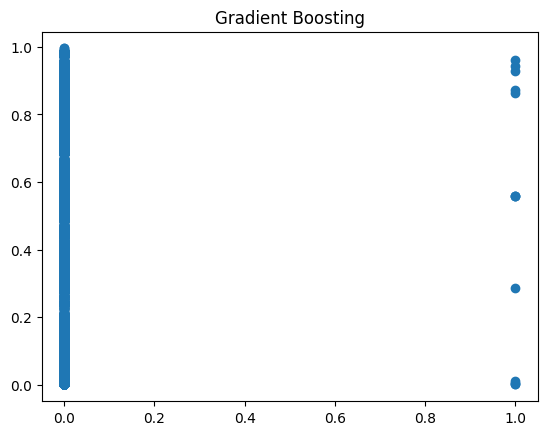

{'Accuracy': 0.7125209213357775, 'Cross-Val Mean': 0.844028615421213, 'Confusion_Matrix': array([[8932, 3602],
       [   5,    8]])}
--------------------------------------
Run time: 1.47 minutes
Current Time: 08:48:06
--------------------------------------

Current Time: 08:48:06
results for target: 5min_stop, model: MLP


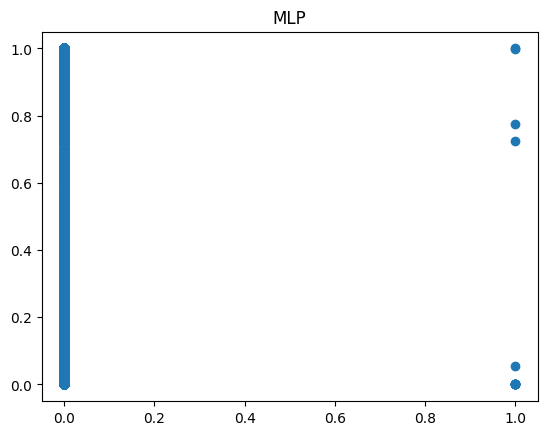

{'Accuracy': 0.7807444010520443, 'Cross-Val Mean': 0.9988407220589277, 'Confusion_Matrix': array([[9792, 2742],
       [   9,    4]])}
--------------------------------------
Run time: 1.81 minutes
Current Time: 08:48:26
--------------------------------------


original true samples: 64, original false samples: 33107
balanced true samples: 3310, balanced false samples: 6620

Current Time: 08:48:27
results for target: 10min_stop, model: Logistic Regression


/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


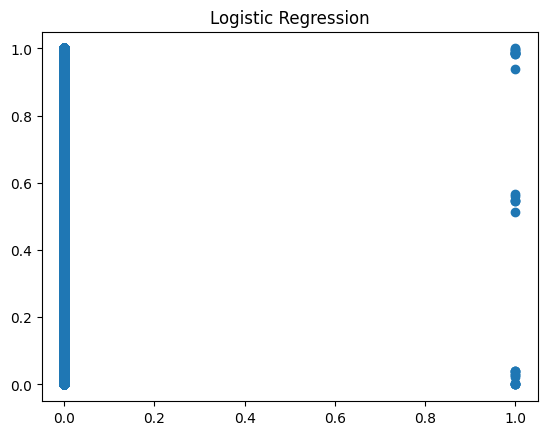

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.5814935841236949, 'Cross-Val Mean': 0.9971127699872036, 'Confusion_Matrix': array([[7279, 5238],
       [  13,   17]])}
--------------------------------------
Run time: 0.04 minutes
Current Time: 08:48:29
--------------------------------------

Current Time: 08:48:29
results for target: 10min_stop, model: Random Forest


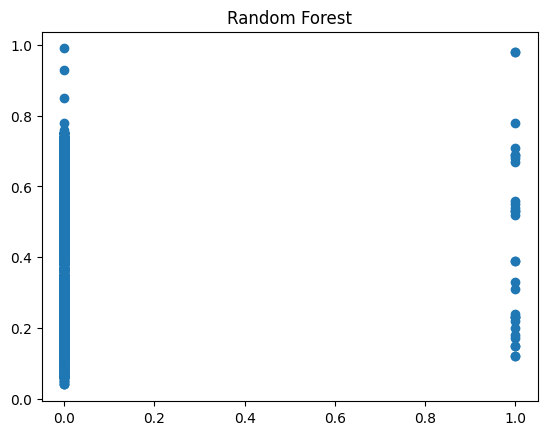

{'Accuracy': 0.6458117478281661, 'Cross-Val Mean': 0.8244311990805372, 'Confusion_Matrix': array([[8089, 4428],
       [  16,   14]])}
--------------------------------------
Run time: 0.43 minutes
Current Time: 08:48:52
--------------------------------------

Current Time: 08:48:52
results for target: 10min_stop, model: Support Vector Machine
{'Accuracy': 0.22363911692037938, 'Cross-Val Mean': 0.9979439184861818, 'Confusion_Matrix': array([[2790, 9727],
       [  14,   16]])}
--------------------------------------
Run time: 0.53 minutes
Current Time: 08:48:58
--------------------------------------

Current Time: 08:48:58
results for target: 10min_stop, model: K-Nearest Neighbors


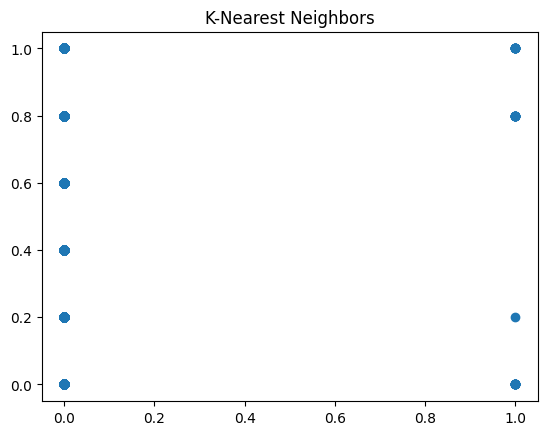

{'Accuracy': 0.3232645253845541, 'Cross-Val Mean': 0.9093174728664769, 'Confusion_Matrix': array([[4038, 8479],
       [  12,   18]])}
--------------------------------------
Run time: 0.57 minutes
Current Time: 08:49:01
--------------------------------------

Current Time: 08:49:01
results for target: 10min_stop, model: Gradient Boosting


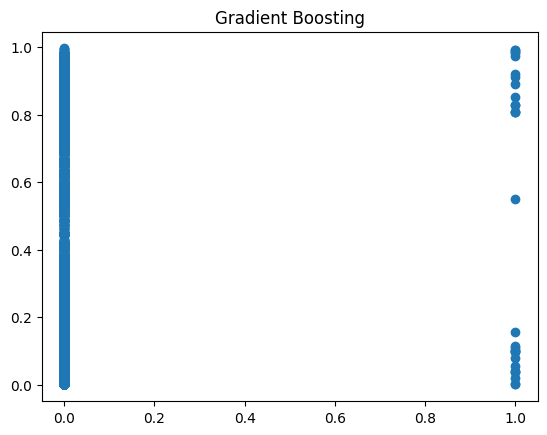

{'Accuracy': 0.5710528413166494, 'Cross-Val Mean': 0.8159884446113272, 'Confusion_Matrix': array([[7150, 5367],
       [  15,   15]])}
--------------------------------------
Run time: 1.49 minutes
Current Time: 08:49:56
--------------------------------------

Current Time: 08:49:56
results for target: 10min_stop, model: MLP


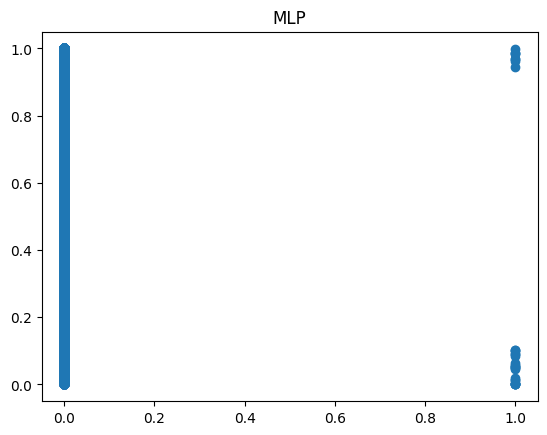

{'Accuracy': 0.5384554076671715, 'Cross-Val Mean': 0.997922046220215, 'Confusion_Matrix': array([[6748, 5769],
       [  22,    8]])}
--------------------------------------
Run time: 1.76 minutes
Current Time: 08:50:12
--------------------------------------


original true samples: 94, original false samples: 33077
balanced true samples: 3307, balanced false samples: 6614

Current Time: 08:50:12
results for target: 15min_stop, model: Logistic Regression


/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


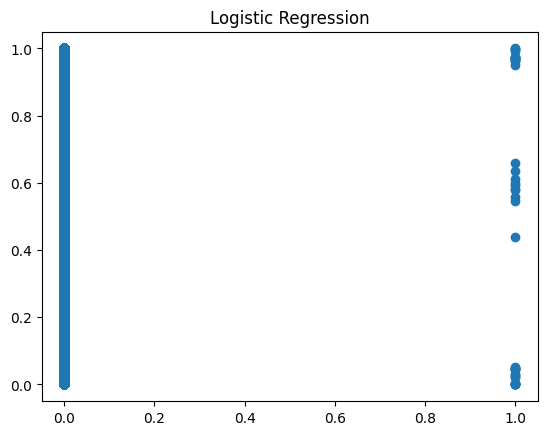

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.5868335060173747, 'Cross-Val Mean': 0.9963034602628079, 'Confusion_Matrix': array([[7340, 5166],
       [  18,   23]])}
--------------------------------------
Run time: 0.04 minutes
Current Time: 08:50:15
--------------------------------------

Current Time: 08:50:15
results for target: 15min_stop, model: Random Forest


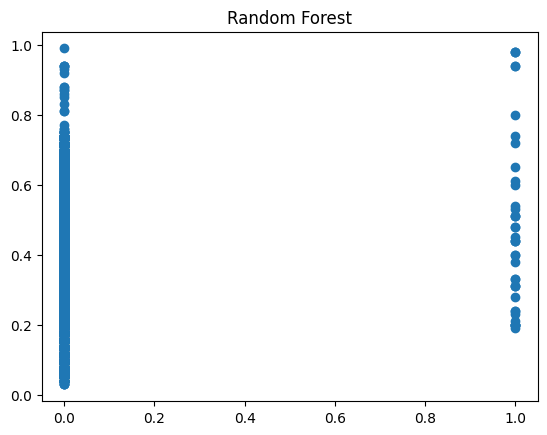

{'Accuracy': 0.6783294811508728, 'Cross-Val Mean': 0.8232499747140052, 'Confusion_Matrix': array([[8495, 4011],
       [  25,   16]])}
--------------------------------------
Run time: 0.44 minutes
Current Time: 08:50:38
--------------------------------------

Current Time: 08:50:38
results for target: 15min_stop, model: Support Vector Machine
{'Accuracy': 0.24364389893998564, 'Cross-Val Mean': 0.9970471149134358, 'Confusion_Matrix': array([[3035, 9471],
       [  19,   22]])}
--------------------------------------
Run time: 0.55 minutes
Current Time: 08:50:45
--------------------------------------

Current Time: 08:50:45
results for target: 15min_stop, model: K-Nearest Neighbors


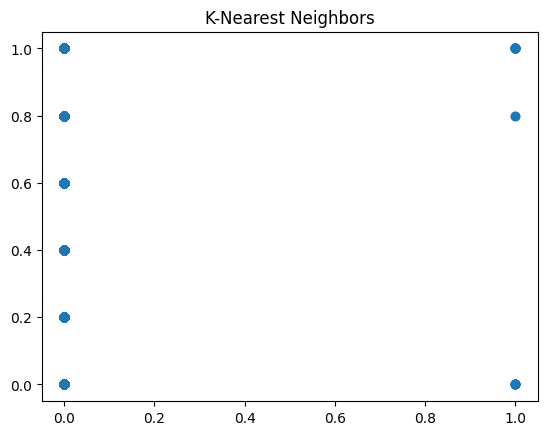

{'Accuracy': 0.11269626205467442, 'Cross-Val Mean': 0.8659884757104696, 'Confusion_Matrix': array([[ 1382, 11124],
       [    9,    32]])}
--------------------------------------
Run time: 0.59 minutes
Current Time: 08:50:48
--------------------------------------

Current Time: 08:50:48
results for target: 15min_stop, model: Gradient Boosting


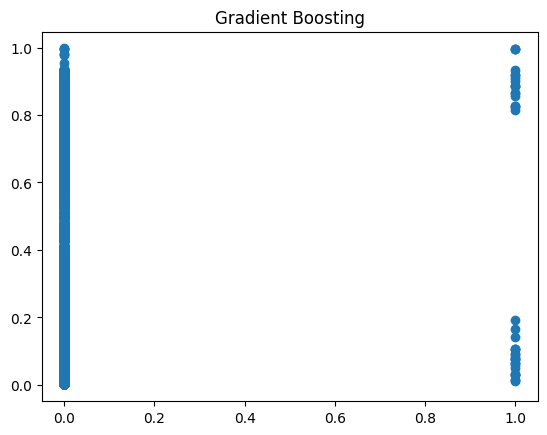

{'Accuracy': 0.5720889455646768, 'Cross-Val Mean': 0.8214127187262481, 'Confusion_Matrix': array([[7160, 5346],
       [  23,   18]])}
--------------------------------------
Run time: 1.47 minutes
Current Time: 08:51:40
--------------------------------------

Current Time: 08:51:40
results for target: 15min_stop, model: MLP


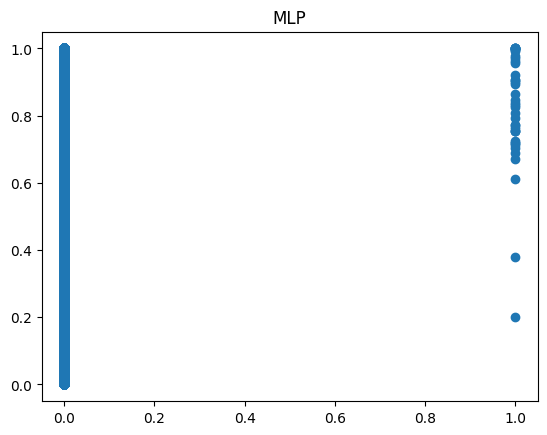

{'Accuracy': 0.3128237825775086, 'Cross-Val Mean': 0.9826317127618154, 'Confusion_Matrix': array([[3886, 8620],
       [   2,   39]])}
--------------------------------------
Run time: 1.73 minutes
Current Time: 08:51:56
--------------------------------------


original true samples: 180, original false samples: 32991
balanced true samples: 3299, balanced false samples: 6598

Current Time: 08:51:56
results for target: 30min_stop, model: Logistic Regression


/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


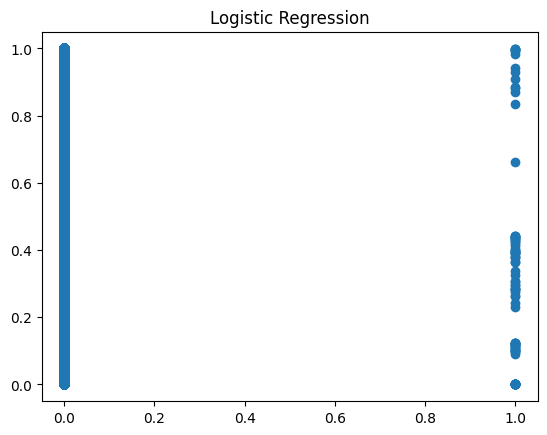

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.6307483860683829, 'Cross-Val Mean': 0.9926942780161886, 'Confusion_Matrix': array([[7899, 4556],
       [  77,   15]])}
--------------------------------------
Run time: 0.03 minutes
Current Time: 08:51:58
--------------------------------------

Current Time: 08:51:58
results for target: 30min_stop, model: Random Forest


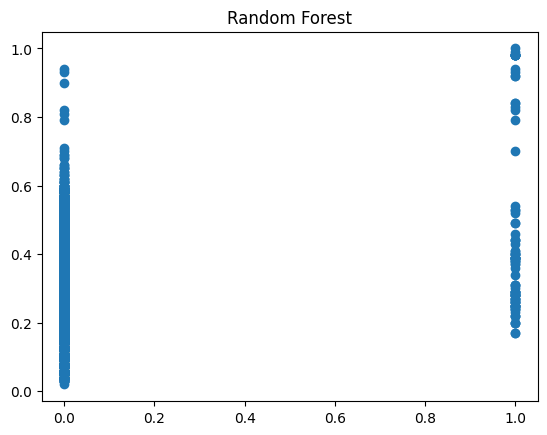

{'Accuracy': 0.8982226827129991, 'Cross-Val Mean': 0.809907105426762, 'Confusion_Matrix': array([[11246,  1209],
       [   68,    24]])}
--------------------------------------
Run time: 0.43 minutes
Current Time: 08:52:22
--------------------------------------

Current Time: 08:52:22
results for target: 30min_stop, model: Support Vector Machine
{'Accuracy': 0.400414441699211, 'Cross-Val Mean': 0.9940504852949381, 'Confusion_Matrix': array([[4997, 7458],
       [  65,   27]])}
--------------------------------------
Run time: 0.58 minutes
Current Time: 08:52:31
--------------------------------------

Current Time: 08:52:31
results for target: 30min_stop, model: K-Nearest Neighbors


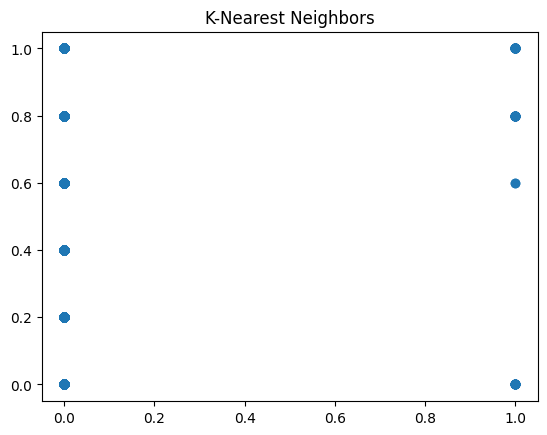

{'Accuracy': 0.28086395154220134, 'Cross-Val Mean': 0.8236651267328323, 'Confusion_Matrix': array([[3452, 9003],
       [  20,   72]])}
--------------------------------------
Run time: 0.63 minutes
Current Time: 08:52:34
--------------------------------------

Current Time: 08:52:34
results for target: 30min_stop, model: Gradient Boosting


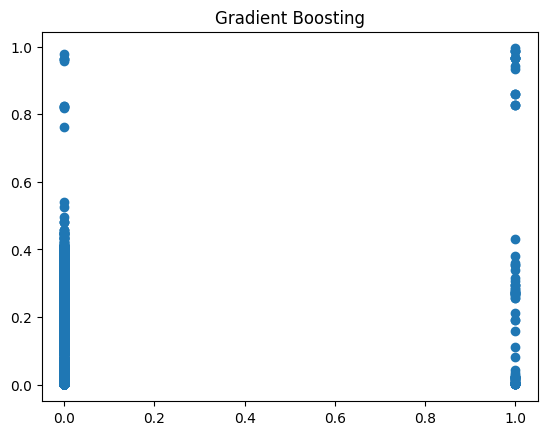

{'Accuracy': 0.9931457718976647, 'Cross-Val Mean': 0.8080472355781078, 'Confusion_Matrix': array([[12442,    13],
       [   73,    19]])}
--------------------------------------
Run time: 1.53 minutes
Current Time: 08:53:28
--------------------------------------

Current Time: 08:53:28
results for target: 30min_stop, model: MLP


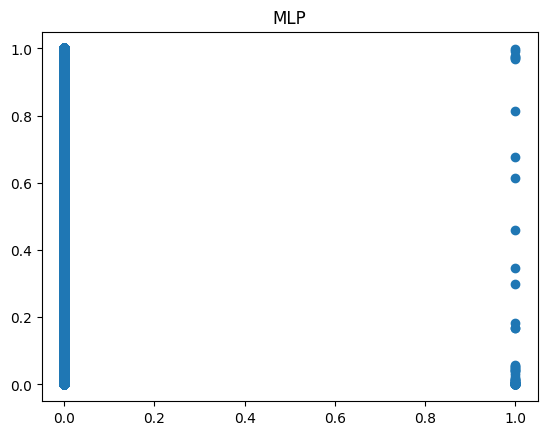

{'Accuracy': 0.7756435801386786, 'Cross-Val Mean': 0.9941379480441462, 'Confusion_Matrix': array([[9723, 2732],
       [  83,    9]])}
--------------------------------------
Run time: 1.99 minutes
Current Time: 08:53:55
--------------------------------------


original true samples: 307, original false samples: 32864
balanced true samples: 3286, balanced false samples: 6572

Current Time: 08:53:55
results for target: 1hour_stop, model: Logistic Regression


/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


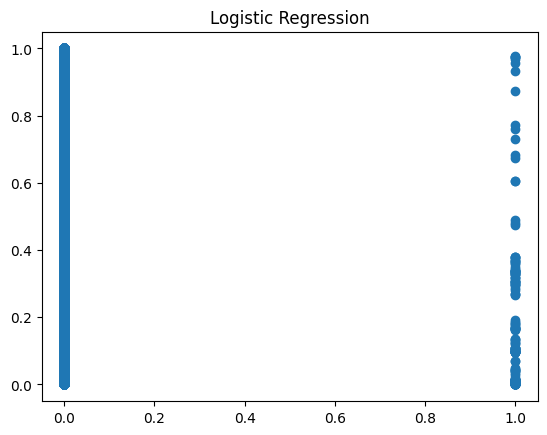

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.6784888818044154, 'Cross-Val Mean': 0.9839228223591159, 'Confusion_Matrix': array([[8498, 3874],
       [ 160,   15]])}
--------------------------------------
Run time: 0.03 minutes
Current Time: 08:53:57
--------------------------------------

Current Time: 08:53:57
results for target: 1hour_stop, model: Random Forest


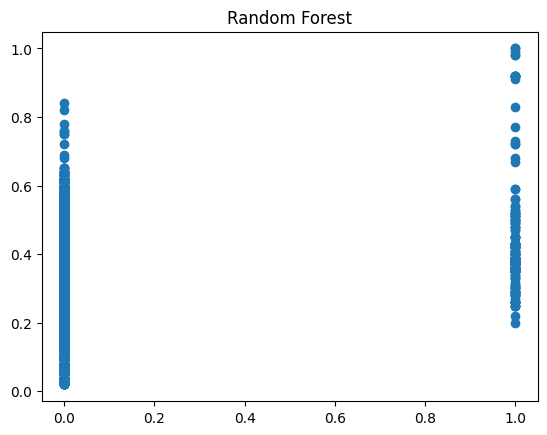

{'Accuracy': 0.9294652108073643, 'Cross-Val Mean': 0.8009611740127147, 'Confusion_Matrix': array([[11627,   745],
       [  140,    35]])}
--------------------------------------
Run time: 0.42 minutes
Current Time: 08:54:21
--------------------------------------

Current Time: 08:54:21
results for target: 1hour_stop, model: Support Vector Machine
{'Accuracy': 0.3621582848489679, 'Cross-Val Mean': 0.989457108493616, 'Confusion_Matrix': array([[4495, 7877],
       [ 126,   49]])}
--------------------------------------
Run time: 0.62 minutes
Current Time: 08:54:33
--------------------------------------

Current Time: 08:54:33
results for target: 1hour_stop, model: K-Nearest Neighbors


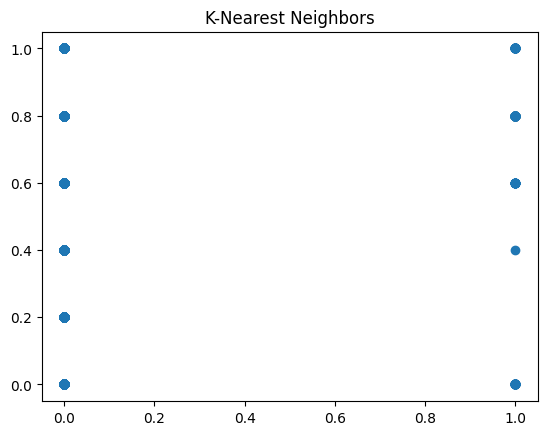

{'Accuracy': 0.2885151829122499, 'Cross-Val Mean': 0.8199685224051139, 'Confusion_Matrix': array([[3486, 8886],
       [  41,  134]])}
--------------------------------------
Run time: 0.66 minutes
Current Time: 08:54:35
--------------------------------------

Current Time: 08:54:35
results for target: 1hour_stop, model: Gradient Boosting


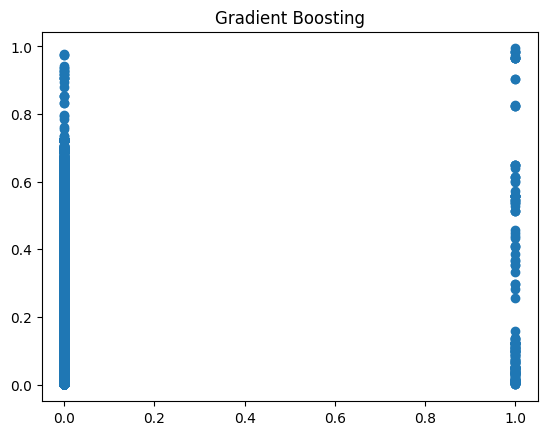

{'Accuracy': 0.7787518928827608, 'Cross-Val Mean': 0.7960388855062591, 'Confusion_Matrix': array([[9724, 2648],
       [ 128,   47]])}
--------------------------------------
Run time: 1.54 minutes
Current Time: 08:55:28
--------------------------------------

Current Time: 08:55:28
results for target: 1hour_stop, model: MLP


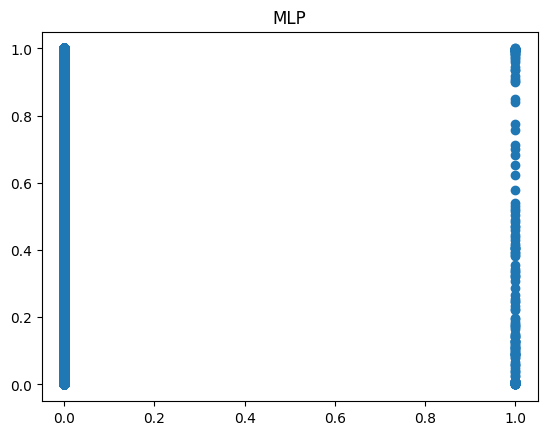

{'Accuracy': 0.5769506654977286, 'Cross-Val Mean': 0.9854544957829086, 'Confusion_Matrix': array([[7185, 5187],
       [ 121,   54]])}
--------------------------------------
Run time: 1.95 minutes
Current Time: 08:55:52
--------------------------------------


original true samples: 558, original false samples: 32613
balanced true samples: 3261, balanced false samples: 6522

Current Time: 08:55:52
results for target: 2hour_stop, model: Logistic Regression


/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


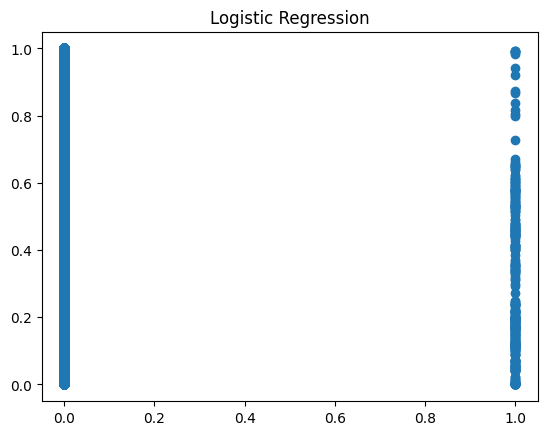

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.5980712520921336, 'Cross-Val Mean': 0.9560988360404419, 'Confusion_Matrix': array([[7429, 4779],
       [ 264,   75]])}
--------------------------------------
Run time: 0.03 minutes
Current Time: 08:55:54
--------------------------------------

Current Time: 08:55:54
results for target: 2hour_stop, model: Random Forest


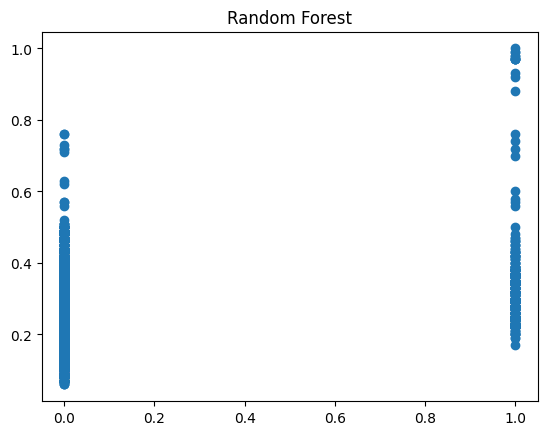

{'Accuracy': 0.9733800908583725, 'Cross-Val Mean': 0.7873975582293162, 'Confusion_Matrix': array([[12192,    16],
       [  318,    21]])}
--------------------------------------
Run time: 0.39 minutes
Current Time: 08:56:16
--------------------------------------

Current Time: 08:56:16
results for target: 2hour_stop, model: Support Vector Machine
{'Accuracy': 0.20028692117637684, 'Cross-Val Mean': 0.9803797210052888, 'Confusion_Matrix': array([[2437, 9771],
       [ 263,   76]])}
--------------------------------------
Run time: 0.71 minutes
Current Time: 08:56:35
--------------------------------------

Current Time: 08:56:35
results for target: 2hour_stop, model: K-Nearest Neighbors


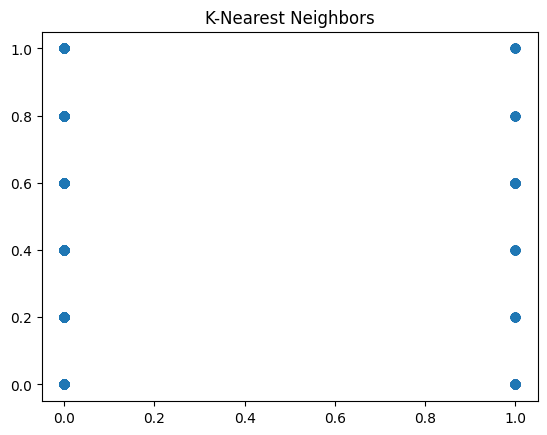

{'Accuracy': 0.4483940384155575, 'Cross-Val Mean': 0.8072598674946885, 'Confusion_Matrix': array([[5469, 6739],
       [ 182,  157]])}
--------------------------------------
Run time: 0.75 minutes
Current Time: 08:56:37
--------------------------------------

Current Time: 08:56:37
results for target: 2hour_stop, model: Gradient Boosting


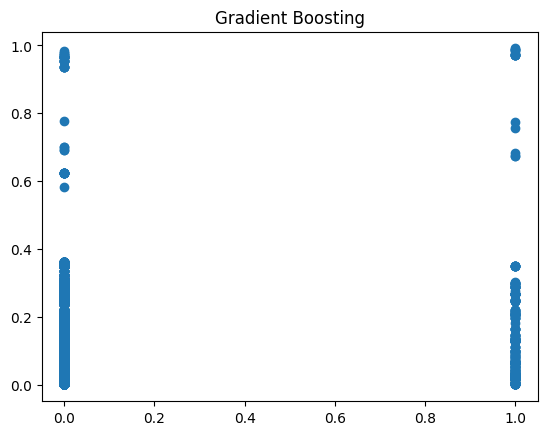

{'Accuracy': 0.9710687813820037, 'Cross-Val Mean': 0.798882481030241, 'Confusion_Matrix': array([[12167,    41],
       [  322,    17]])}
--------------------------------------
Run time: 1.62 minutes
Current Time: 08:57:29
--------------------------------------

Current Time: 08:57:29
results for target: 2hour_stop, model: MLP


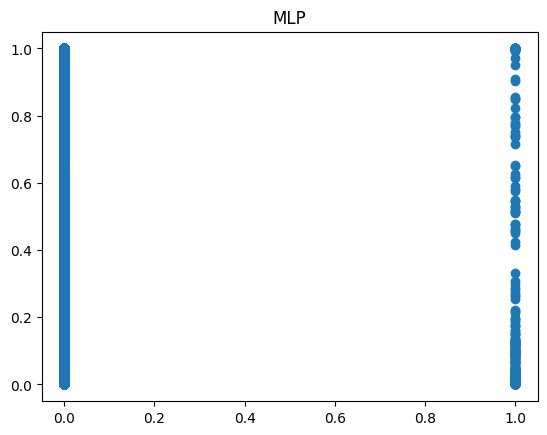

{'Accuracy': 0.7688690523631146, 'Cross-Val Mean': 0.9699017525467089, 'Confusion_Matrix': array([[9587, 2621],
       [ 279,   60]])}
--------------------------------------
Run time: 2.15 minutes
Current Time: 08:58:01
--------------------------------------


original true samples: 803, original false samples: 32368
balanced true samples: 3236, balanced false samples: 6472

Current Time: 08:58:01
results for target: 3hour_stop, model: Logistic Regression


/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


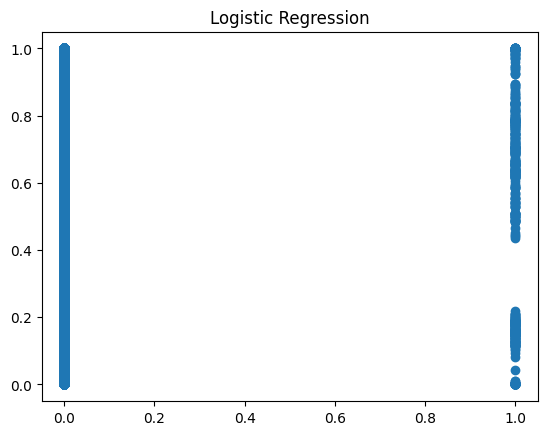

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.5513668606041284, 'Cross-Val Mean': 0.931796851503701, 'Confusion_Matrix': array([[6622, 5434],
       [ 195,  296]])}
--------------------------------------
Run time: 0.03 minutes
Current Time: 08:58:03
--------------------------------------

Current Time: 08:58:03
results for target: 3hour_stop, model: Random Forest


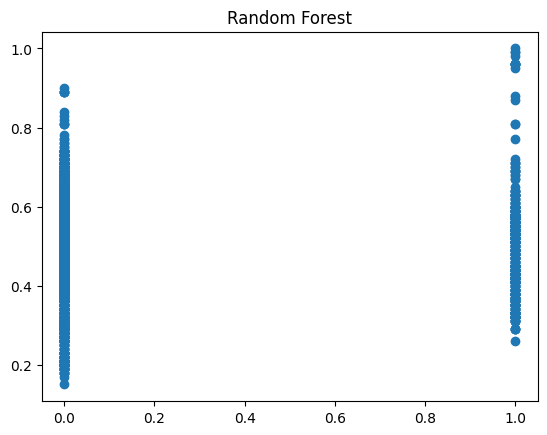

{'Accuracy': 0.46616721128556626, 'Cross-Val Mean': 0.7804416633199205, 'Confusion_Matrix': array([[5602, 6454],
       [ 244,  247]])}
--------------------------------------
Run time: 0.36 minutes
Current Time: 08:58:22
--------------------------------------

Current Time: 08:58:22
results for target: 3hour_stop, model: Support Vector Machine
{'Accuracy': 0.37881565314417787, 'Cross-Val Mean': 0.9716960510500552, 'Confusion_Matrix': array([[4694, 7362],
       [ 432,   59]])}
--------------------------------------
Run time: 0.78 minutes
Current Time: 08:58:48
--------------------------------------

Current Time: 08:58:48
results for target: 3hour_stop, model: K-Nearest Neighbors


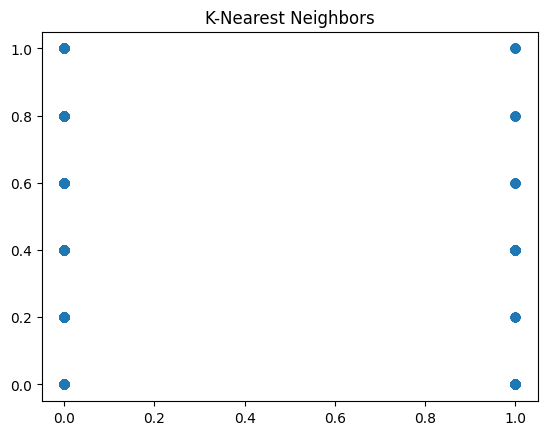

{'Accuracy': 0.5295289710687814, 'Cross-Val Mean': 0.7969354020099997, 'Confusion_Matrix': array([[6504, 5552],
       [ 351,  140]])}
--------------------------------------
Run time: 0.83 minutes
Current Time: 08:58:50
--------------------------------------

Current Time: 08:58:50
results for target: 3hour_stop, model: Gradient Boosting


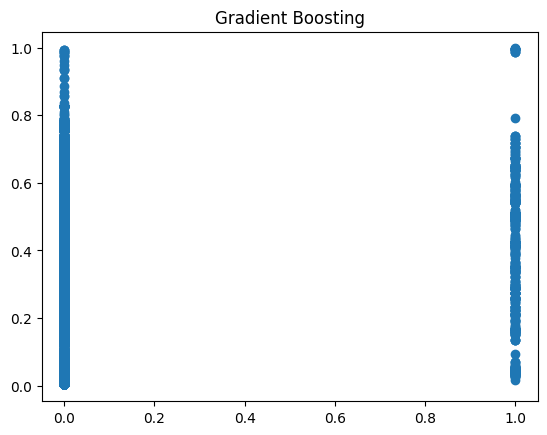

{'Accuracy': 0.5677054275922532, 'Cross-Val Mean': 0.798706888096387, 'Confusion_Matrix': array([[6952, 5104],
       [ 320,  171]])}
--------------------------------------
Run time: 1.72 minutes
Current Time: 08:59:44
--------------------------------------

Current Time: 08:59:44
results for target: 3hour_stop, model: MLP


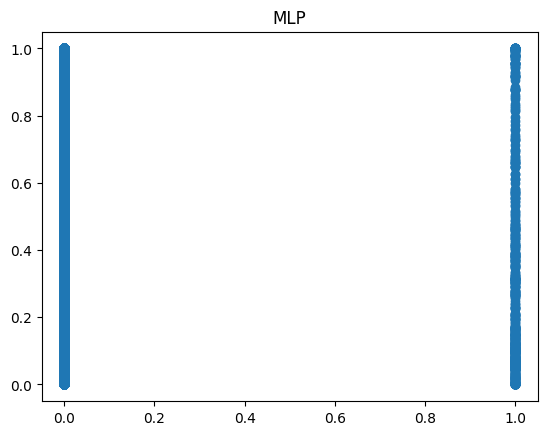

{'Accuracy': 0.44871283972264286, 'Cross-Val Mean': 0.9412248315837912, 'Confusion_Matrix': array([[5506, 6550],
       [ 367,  124]])}
--------------------------------------
Run time: 2.16 minutes
Current Time: 09:00:10
--------------------------------------


original true samples: 1658, original false samples: 31513
balanced true samples: 3151, balanced false samples: 6302

Current Time: 09:00:10
results for target: 6hour_stop, model: Logistic Regression


/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


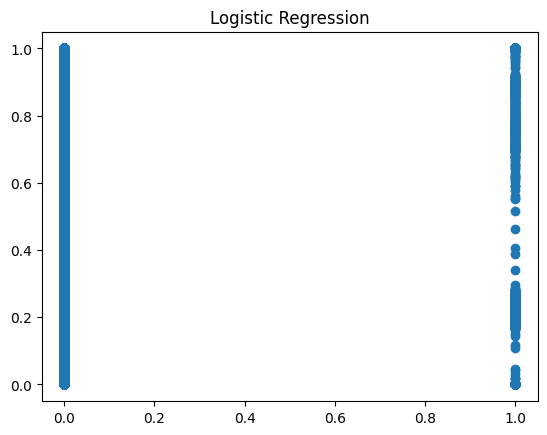

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.5398103132222842, 'Cross-Val Mean': 0.7356184648142869, 'Confusion_Matrix': array([[6279, 5381],
       [ 393,  494]])}
--------------------------------------
Run time: 0.03 minutes
Current Time: 09:00:12
--------------------------------------

Current Time: 09:00:12
results for target: 6hour_stop, model: Random Forest


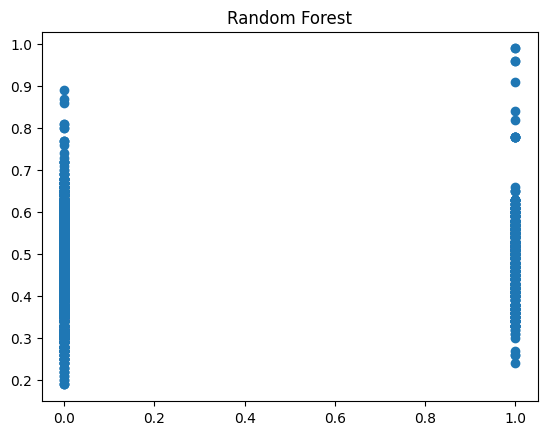

{'Accuracy': 0.6101060014346059, 'Cross-Val Mean': 0.7826513745964409, 'Confusion_Matrix': array([[7201, 4459],
       [ 433,  454]])}
--------------------------------------
Run time: 0.36 minutes
Current Time: 09:00:32
--------------------------------------

Current Time: 09:00:32
results for target: 6hour_stop, model: Support Vector Machine
{'Accuracy': 0.5060173746712362, 'Cross-Val Mean': 0.8181515454503439, 'Confusion_Matrix': array([[6212, 5448],
       [ 750,  137]])}
--------------------------------------
Run time: 1.10 minutes
Current Time: 09:01:16
--------------------------------------

Current Time: 09:01:16
results for target: 6hour_stop, model: K-Nearest Neighbors


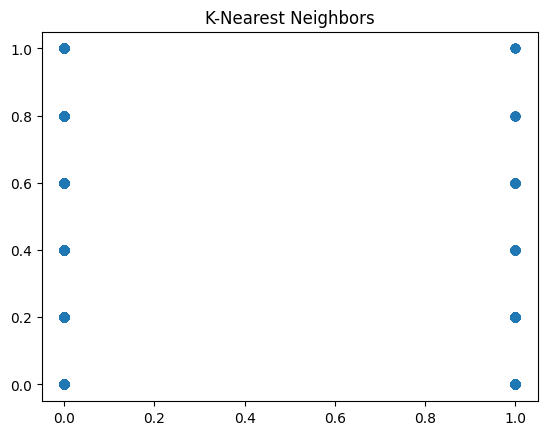

{'Accuracy': 0.6910815334342871, 'Cross-Val Mean': 0.7631832660969877, 'Confusion_Matrix': array([[8543, 3117],
       [ 759,  128]])}
--------------------------------------
Run time: 1.14 minutes
Current Time: 09:01:19
--------------------------------------

Current Time: 09:01:19
results for target: 6hour_stop, model: Gradient Boosting


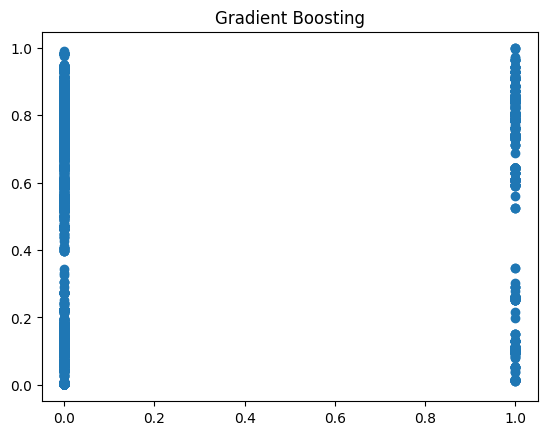

{'Accuracy': 0.4680003188013071, 'Cross-Val Mean': 0.7864356545828797, 'Confusion_Matrix': array([[5230, 6430],
       [ 245,  642]])}
--------------------------------------
Run time: 2.02 minutes
Current Time: 09:02:11
--------------------------------------

Current Time: 09:02:11
results for target: 6hour_stop, model: MLP


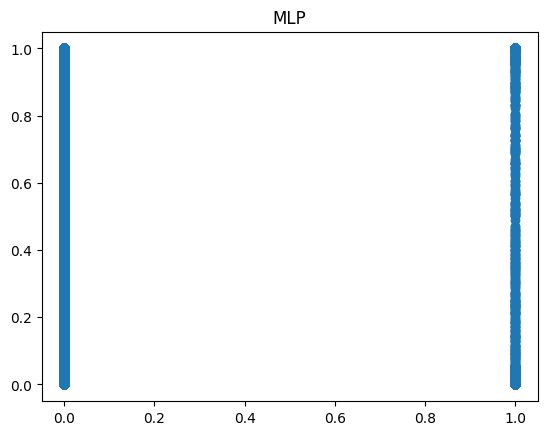

{'Accuracy': 0.30007173029409423, 'Cross-Val Mean': 0.90659892460123, 'Confusion_Matrix': array([[3303, 8357],
       [ 425,  462]])}
--------------------------------------
Run time: 2.68 minutes
Current Time: 09:02:51
--------------------------------------


original true samples: 3227, original false samples: 29944
errored on balanced dataset: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio., using raw dataset
balanced true samples: 3227, balanced false samples: 29944

Current Time: 09:02:51
results for target: 12hour_stop, model: Logistic Regression


/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


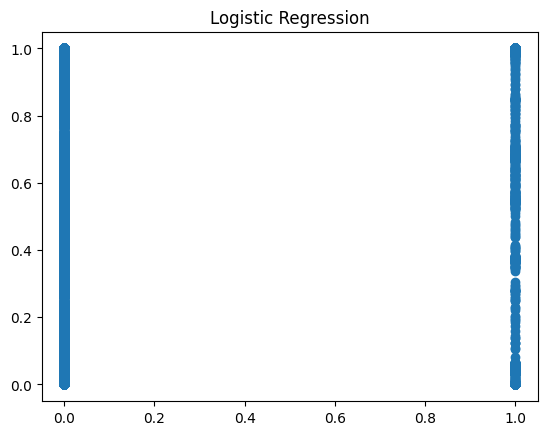

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.6500358651470471, 'Cross-Val Mean': 0.7040769348761953, 'Confusion_Matrix': array([[7455, 3454],
       [ 937,  701]])}
--------------------------------------
Run time: 0.03 minutes
Current Time: 09:02:53
--------------------------------------

Current Time: 09:02:53
results for target: 12hour_stop, model: Random Forest


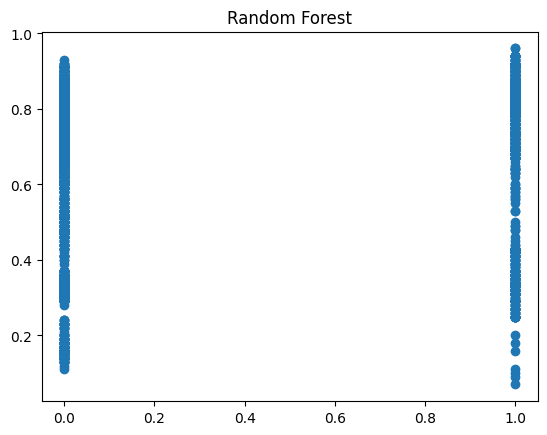

{'Accuracy': 0.21654578783773012, 'Cross-Val Mean': 0.6867950721543161, 'Confusion_Matrix': array([[1324, 9585],
       [ 245, 1393]])}
--------------------------------------
Run time: 0.40 minutes
Current Time: 09:03:15
--------------------------------------

Current Time: 09:03:15
results for target: 12hour_stop, model: Support Vector Machine
{'Accuracy': 0.5012353550649558, 'Cross-Val Mean': 0.7773356771560724, 'Confusion_Matrix': array([[6170, 4739],
       [1519,  119]])}
--------------------------------------
Run time: 1.94 minutes
Current Time: 09:04:47
--------------------------------------

Current Time: 09:04:47
results for target: 12hour_stop, model: K-Nearest Neighbors


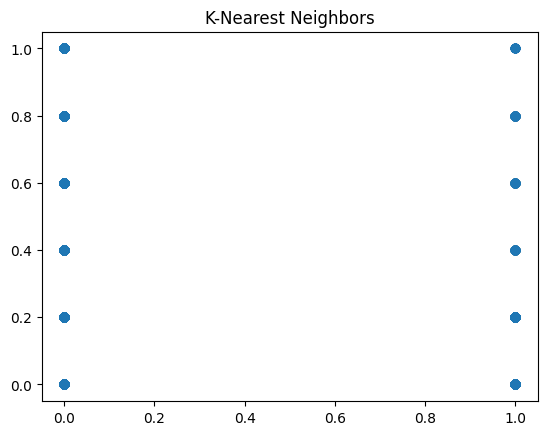

{'Accuracy': 0.5168566191121383, 'Cross-Val Mean': 0.7235680902322953, 'Confusion_Matrix': array([[6298, 4611],
       [1451,  187]])}
--------------------------------------
Run time: 1.99 minutes
Current Time: 09:04:50
--------------------------------------

Current Time: 09:04:50
results for target: 12hour_stop, model: Gradient Boosting


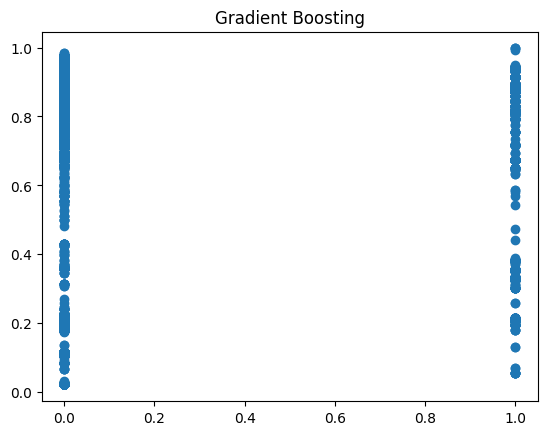

{'Accuracy': 0.2152705826093887, 'Cross-Val Mean': 0.7241790209205365, 'Confusion_Matrix': array([[1348, 9561],
       [ 285, 1353]])}
--------------------------------------
Run time: 2.97 minutes
Current Time: 09:05:49
--------------------------------------

Current Time: 09:05:49
results for target: 12hour_stop, model: MLP


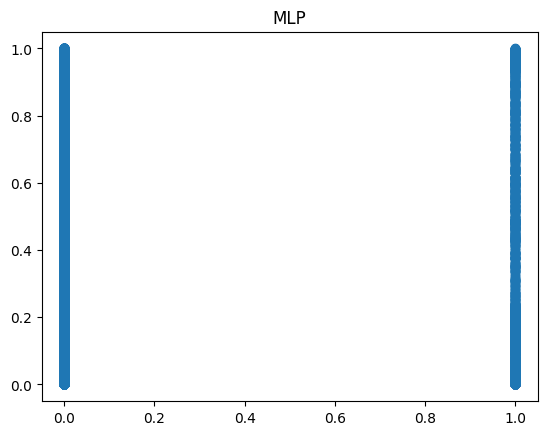

{'Accuracy': 0.5331154857734917, 'Cross-Val Mean': 0.708781323654132, 'Confusion_Matrix': array([[6113, 4796],
       [1062,  576]])}
--------------------------------------
Run time: 3.23 minutes
Current Time: 09:06:05
--------------------------------------


original true samples: 5482, original false samples: 27689
errored on balanced dataset: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio., using raw dataset
balanced true samples: 5482, balanced false samples: 27689

Current Time: 09:06:05
results for target: 24hour_stop, model: Logistic Regression


/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


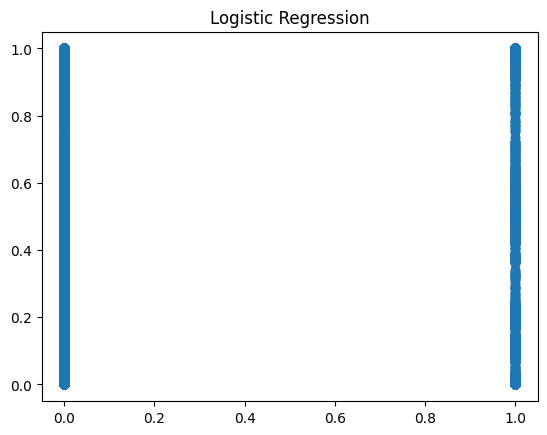

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.6445365425998246, 'Cross-Val Mean': 0.6946941107506481, 'Confusion_Matrix': array([[6807, 2607],
       [1853, 1280]])}
--------------------------------------
Run time: 0.04 minutes
Current Time: 09:06:07
--------------------------------------

Current Time: 09:06:07
results for target: 24hour_stop, model: Random Forest


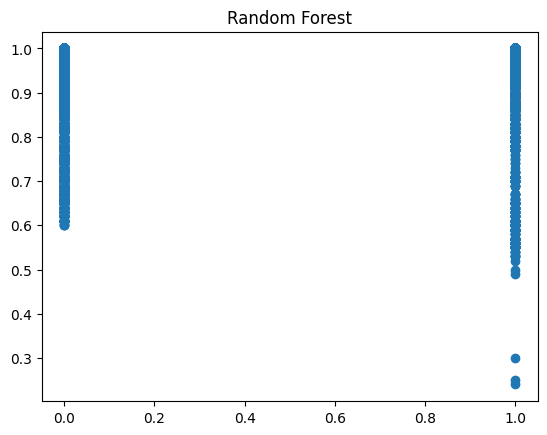

{'Accuracy': 0.24930262214075077, 'Cross-Val Mean': 0.5864387477514124, 'Confusion_Matrix': array([[   0, 9414],
       [   5, 3128]])}
--------------------------------------
Run time: 0.42 minutes
Current Time: 09:06:30
--------------------------------------

Current Time: 09:06:30
results for target: 24hour_stop, model: Support Vector Machine
{'Accuracy': 0.47286203873435884, 'Cross-Val Mean': 0.7309406658029717, 'Confusion_Matrix': array([[4846, 4568],
       [2046, 1087]])}
--------------------------------------
Run time: 3.09 minutes
Current Time: 09:09:10
--------------------------------------

Current Time: 09:09:10
results for target: 24hour_stop, model: K-Nearest Neighbors


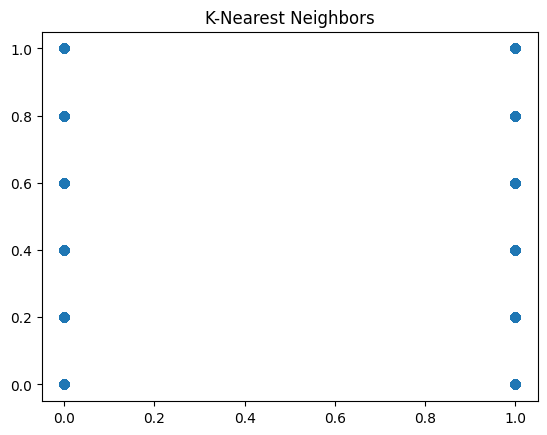

{'Accuracy': 0.251693631943891, 'Cross-Val Mean': 0.6298356965332303, 'Confusion_Matrix': array([[1251, 8163],
       [1226, 1907]])}
--------------------------------------
Run time: 3.14 minutes
Current Time: 09:09:13
--------------------------------------

Current Time: 09:09:13
results for target: 24hour_stop, model: Gradient Boosting


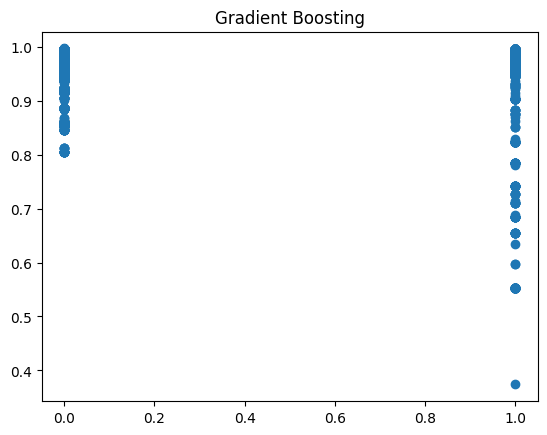

{'Accuracy': 0.24962142344783614, 'Cross-Val Mean': 0.6571748902846184, 'Confusion_Matrix': array([[   0, 9414],
       [   1, 3132]])}
--------------------------------------
Run time: 4.11 minutes
Current Time: 09:10:12
--------------------------------------

Current Time: 09:10:12
results for target: 24hour_stop, model: MLP


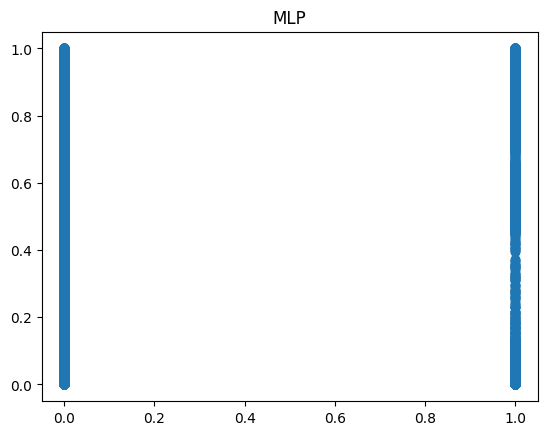

{'Accuracy': 0.4514226508328684, 'Cross-Val Mean': 0.7095250931323621, 'Confusion_Matrix': array([[3626, 5788],
       [1095, 2038]])}
--------------------------------------
Run time: 4.75 minutes
Current Time: 09:10:50
--------------------------------------




In [36]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

import seaborn as sns

import time
import pickle

print('input variables:')
for var in model_input.columns:
    print(var)

# Define the models to test
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP' : MLPClassifier(hidden_layer_sizes=(16, 32), max_iter=1000)
}

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
for targ in target_features:
    if targ not in results:
        start_time = time.time()
        
        results[targ] = dict()
        output_models[targ] = dict()
    #y = model_output[targ].values
    
    X_train = model_input_train[model_output_train[targ].notnull()].values
    X_test = model_input_test[model_output_test[targ].notnull()].values
    
    Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
    Y_test = model_output_test[model_output_test[targ].notnull()][targ].values
    
    # Split the data into training and testing sets
    #X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    n_true = np.sum((Y_train == 1))
    n_false = np.sum((Y_train == 0))
    print(f'original true samples: {n_true}, original false samples: {n_false}')
    try:
        X_train, Y_train = balance_dataset(X_train, Y_train)
    except Exception as e:
        print(f'errored on balanced dataset: {e}, using raw dataset')
    
    saved_processed_data[targ] = (X_train, Y_train)
    
    n_true = np.sum((Y_train == 1))
    n_false = np.sum((Y_train == 0))
    print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
    for name, model in models.items():
        print()
        print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
        print(f'results for target: {targ}, model: {name}')
        model.fit(X_train, Y_train)
        output_models[targ][name] = model
        
        predictions = model.predict(X_test)
        
        try:
            probs = model.predict_proba(X_test)
            plt.scatter(Y_test, probs[:,1])
            plt.title(f'{name}')
            plt.show()
        except:
            pass
        #break
        # Compute the confusion matrix
        conf_matrix = confusion_matrix(Y_test, predictions)

        accuracy = accuracy_score(Y_test, predictions)
        cross_val = cross_val_score(
            model, 
            model_input.values, 
            model_output[targ].values, 
            cv=5
        )
        results[targ][name] = {'Accuracy': accuracy, 'Cross-Val Mean': np.mean(cross_val),
                              'Confusion_Matrix' : conf_matrix}

        
        print(results[targ][name])
        print('--------------------------------------')
        
        duration = time.time() - start_time
        print(f"Run time: {duration / 60:.2f} minutes")
        print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
        print('--------------------------------------')
    print()
    print()
    



array([[9.08385042e-01, 9.16149583e-02],
       [4.78587508e-01, 5.21412492e-01],
       [8.04695293e-01, 1.95304707e-01],
       ...,
       [9.99999669e-01, 3.30522030e-07],
       [9.99999621e-01, 3.79145245e-07],
       [9.99999604e-01, 3.96266360e-07]])

In [33]:
Y_test

array([ True,  True,  True, ...,  True,  True,  True])

In [37]:
with open('models_tempsplit_no_screw_speed_no_5T_ex4.pkl', 'wb') as f:
    pickle.dump((output_models, results), f)

In [38]:
target_features = [s+ '_stop' for s in stop_target_to_hours_map.keys()]
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-15min_avg',
    'pressure-30min_avg',
    'pressure-1hour_avg',
    'pressure-2hour_avg',
    'pressure-3hour_avg',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'screw_speed_output-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'screw_speed_output-1hour_avg',
    'die_temp-3hour_avg',
    'thrust-3hour_avg',
    'screw_speed_output-3hour_avg',
]

In [39]:
model_input = ex4_data[input_features]
model_output = ex4_data[target_features]

In [40]:
train_split_cutoff = pd.to_datetime('04/01/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
pressure-15min_avg
pressure-30min_avg
pressure-1hour_avg
pressure-2hour_avg
pressure-3hour_avg
die_temp-15min_avg
thrust-15min_avg
screw_speed_output-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
screw_speed_output-1hour_avg
die_temp-3hour_avg
thrust-3hour_avg
screw_speed_output-3hour_avg
original true samples: 34, original false samples: 33137
balanced true samples: 3313, balanced false samples: 6626

Current Time: 09:10:50
results for target: 5min_stop, model: Logistic Regression


/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


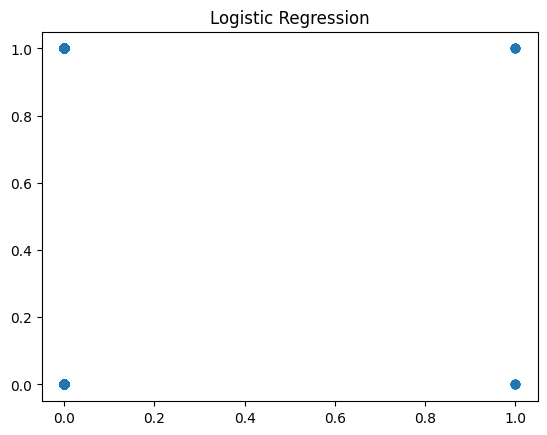

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.6292340798597275, 'Cross-Val Mean': 0.998250173270067, 'Confusion_Matrix': array([[7888, 4646],
       [   6,    7]])}
--------------------------------------
Run time: 0.04 minutes
Current Time: 09:10:53
--------------------------------------

Current Time: 09:10:53
results for target: 5min_stop, model: Random Forest


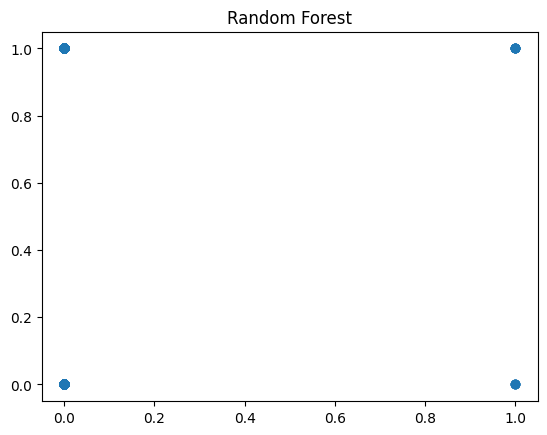

{'Accuracy': 0.7653622379851758, 'Cross-Val Mean': 0.8375546328200827, 'Confusion_Matrix': array([[9595, 2939],
       [   5,    8]])}
--------------------------------------
Run time: 0.42 minutes
Current Time: 09:11:16
--------------------------------------

Current Time: 09:11:16
results for target: 5min_stop, model: Support Vector Machine


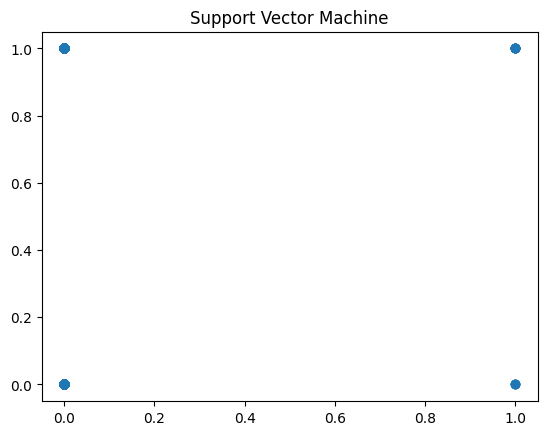

{'Accuracy': 0.09085837251932732, 'Cross-Val Mean': 0.9989719604392118, 'Confusion_Matrix': array([[ 1131, 11403],
       [    4,     9]])}
--------------------------------------
Run time: 0.50 minutes
Current Time: 09:11:20
--------------------------------------

Current Time: 09:11:20
results for target: 5min_stop, model: K-Nearest Neighbors


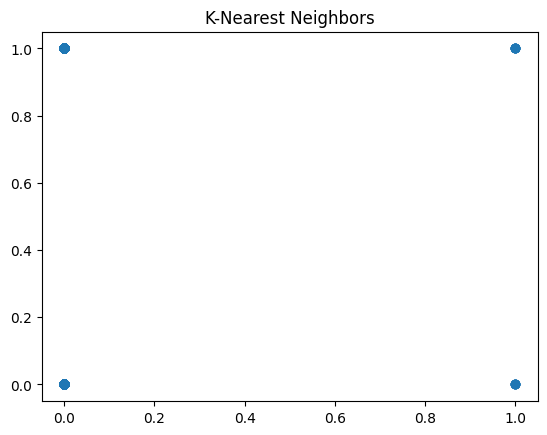

{'Accuracy': 0.4864907946122579, 'Cross-Val Mean': 0.9984470260560098, 'Confusion_Matrix': array([[6097, 6437],
       [   6,    7]])}
--------------------------------------
Run time: 0.54 minutes
Current Time: 09:11:23
--------------------------------------

Current Time: 09:11:23
results for target: 5min_stop, model: Gradient Boosting


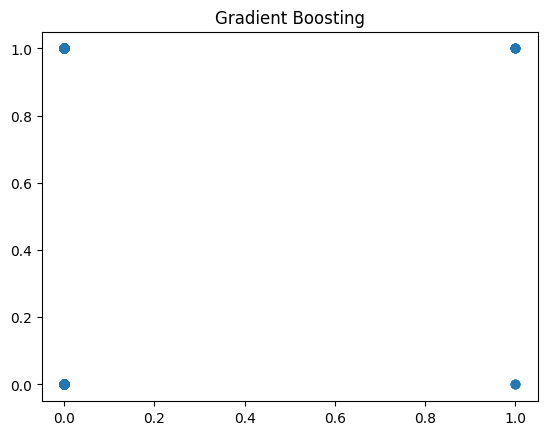

{'Accuracy': 0.7483063680561091, 'Cross-Val Mean': 0.8418195165585708, 'Confusion_Matrix': array([[9380, 3154],
       [   4,    9]])}
--------------------------------------
Run time: 1.45 minutes
Current Time: 09:12:17
--------------------------------------

Current Time: 09:12:17
results for target: 5min_stop, model: MLP


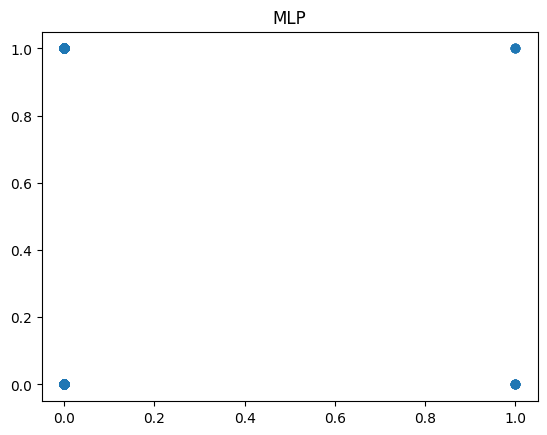

{'Accuracy': 0.8544672033155336, 'Cross-Val Mean': 0.9985563873858435, 'Confusion_Matrix': array([[10716,  1818],
       [    8,     5]])}
--------------------------------------
Run time: 1.63 minutes
Current Time: 09:12:28
--------------------------------------


original true samples: 64, original false samples: 33107
errored on balanced dataset: Found input variables with inconsistent numbers of samples: [9939, 33171], using raw dataset
balanced true samples: 64, balanced false samples: 33107

Current Time: 09:12:28
results for target: 10min_stop, model: Logistic Regression


ValueError: Found input variables with inconsistent numbers of samples: [9939, 33171]

In [41]:
X_train = model_input_train.values
X_test = model_input_test.values

print('input variables:')
for var in model_input.columns:
    print(var)
#y = model_output.values

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models to test
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP' : MLPClassifier(hidden_layer_sizes=(16, 32), max_iter=1000)
}

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
for targ in target_features:
    if targ not in results:
        start_time = time.time()
        
        results[targ] = dict()
        output_models[targ] = dict()
    #y = model_output[targ].values
    Y_train = model_output_train[targ].values
    Y_test = model_output_test[targ].values
    
    # Split the data into training and testing sets
    #X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    n_true = np.sum((Y_train == 1))
    n_false = np.sum((Y_train == 0))
    print(f'original true samples: {n_true}, original false samples: {n_false}')
    try:
        X_train, Y_train = balance_dataset(X_train, Y_train)
    except Exception as e:
        print(f'errored on balanced dataset: {e}, using raw dataset')
    
    saved_processed_data[targ] = (X_train, Y_train)
    
    n_true = np.sum((Y_train == 1))
    n_false = np.sum((Y_train == 0))
    print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
    for name, model in models.items():
        print()
        print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
        print(f'results for target: {targ}, model: {name}')
        model.fit(X_train, Y_train)
        output_models[targ][name] = model
        
        predictions = model.predict(X_test)
        
        # Compute the confusion matrix
        conf_matrix = confusion_matrix(Y_test, predictions)
        
        plt.scatter(Y_test, predictions)
        plt.title(f'{name}')
        plt.show()

        # Visualize the confusion matrix
        accuracy = accuracy_score(Y_test, predictions)
        cross_val = cross_val_score(
            model, 
            model_input.values, 
            model_output[targ].values, 
            cv=5
        )
        results[targ][name] = {'Accuracy': accuracy, 'Cross-Val Mean': np.mean(cross_val),
                              'Confusion_Matrix' : conf_matrix}
        
        
        print(results[targ][name])
        print('--------------------------------------')
        
        duration = time.time() - start_time
        print(f"Run time: {duration / 60:.2f} minutes")
        print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
        print('--------------------------------------')
        
    results_df = pd.DataFrame(results[targ]).T

    print()
    print()

In [ ]:
with open('models_tempsplit_with_screw_speed_no_5T_ex4.pkl', 'wb') as f:
    pickle.dump((output_models, results), f)